# Предсказание самого прибыльного месторождения

##### Вводная: <a class="tocSkip">
    
Увидев ваш сильный результат на прошедших соревнованиях с вами связалась крупная нефтедобывающая компания "Vankor Petroleum". В компании хотят автоматизировать процесс выбора скважин и региона для добычи нефти. В рамках пилотного проекта вам предстоит проанализировать синтетические данные о трех регионах и построить модель машинного обучения, которая определит тот регион, где добыча принесёт наибольшую прибыль. 

### Цель <a class="tocSkip">
    
Построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски.

### Условия задачи: <a class="tocSkip">

- Для обучения модели требуется использовать линейную регрессию (остальные модели недостаточно предсказуемые).  
- При разведке региона исследуются 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
- Бюджет на разработку скважин в регионе — 10 млрд рублей.  
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, т.к. объём указан в тысячах баррелей.  
- После оценки рисков оставляют лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### Описание данных <a class="tocSkip">

Данные геологоразведки трёх регионов находятся в трёх файлах.  
`id` — уникальный идентификатор скважины;  
`f0, f1, f2` — три признака точек (неизвестно что они означают, но сами признаки значимы);  
`product` — объём запасов в скважине (тыс. баррелей).

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### План <a class="tocSkip">

    1. Загрузка и подготовка данных. 
    2. Обучение и проверка модели для каждого региона.
    3. Подготовка к расчёту прибыли:  
        3.1. Создание переменных с ключевыми значениями.  
        3.2. Рассчёт достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение полученного объёма сырья со средним запасом в каждом регионе.  
        3.3. Выводы по этапу подготовки расчёта прибыли.  
    4. Расчёт прибыли по выбранным скважинам и предсказаниям модели.  
    5. Риски и прибыль для каждого региона:  
        5.1. Поиск распределения прибыли техникой Bootstrap с 1000 выборок.  
        5.2. Средняя прибыль, 95%-й доверительный интервал и риск убытков.  
        5.3. Выводы: выбор региона для разработки скважин и его обоснование.  
    6. Общий вывод.

## 0. Установка библиотек <a class="tocSkip">

In [1]:
%%capture
%pip install --upgrade ipykernel
%pip install dill
%pip install seaborn>=0.11 -U
%pip install scikit-learn -U

In [2]:
import dill 

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression

from sklearn.metrics import (mean_squared_error as mse, 
                             mean_absolute_error as mae)

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

#фильтр предупреждений
import warnings
#warnings.simplefilter("ignore")

In [3]:
#зададим ramdom seed
RS = 2021

## 1. Загрузка и подготовка данных

In [4]:
data_region_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_region_0.name = 'data_region_0'

data_region_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
data_region_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_region_1.name = 'data_region_1'

data_region_1.head(3)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


In [6]:
data_region_2 = pd.read_csv('/datasets/geo_data_2.csv')
data_region_2.name = 'data_region_2'

data_region_2.head(3)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


In [7]:
data_list = [data_region_0, data_region_1, data_region_2]


def process_all_df(function_name, data_list):
    for df in data_list:
        print("\033[1m" + df.name + "\033[0m" )
        function_name(df)
        print()
        
        
def df_info(df):
    return print(df.info())
    

process_all_df(df_info, data_list)

data_region_0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

data_region_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

data_region_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null f

Пропусков в таблицах нет. Все типы данных определились адекватно задаче.

#### Обработка дубликатов

In [8]:
def df_duplicated(df):
    return print(df.duplicated().sum())
    

process_all_df(df_duplicated, data_list)

data_region_0
0

data_region_1
0

data_region_2
0



Полных дубликатов нет. Посмотрим есть ли дубликаты-скважины:

In [9]:
def df_duplicated_id(df):
    return print(df['id'].duplicated().sum())
    

process_all_df(df_duplicated_id, data_list)

data_region_0
10

data_region_1
4

data_region_2
4



In [10]:
#выведем дублирующиеся строки
def df_duplicated_id(df):
    return print(df[df['id'].duplicated(keep=False) == True])
    

process_all_df(df_duplicated_id, data_list)

data_region_0
          id        f0        f1         f2     product
931    HZww2  0.755284  0.368511   1.863211   30.681774
1364   bxg6G  0.411645  0.856830  -3.653440   73.604260
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
16633  fiKDv  0.157341  1.028359   5.585586   95.817889
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
64022  74z30  0.741456  0.459229   5.153109  140.771492
66136  74z30  1.084962 -0.312358   6.990771  127.643327
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
89582  bsk9y  0.398908 -0.400253  

Как видим, некоторые скважины появляются по 2 раза, при этом с разными признаками. Какой-либо временной связи в данных, упорядоченных изначальным способом, не наблюдается – количество продукта может как и расти, так и падать от наблюдения к наблюдению. 

Возможная причина появления дубликатов – были произведены повторные замеры признаков и старые данные по какой-либо причине не удалены. 

Так как мы не можем определить актуальные значения признаков, будем удалять обе записи о скважинах. Во-первых этим действием мы скореее всего улучшим качество нашей модели, во-вторых доля таких скважин очень мала, поэтому их удаление не должно сильно повлиять на конечный результат.

In [11]:
def df_drop_duplicated_id(df):
    return df.drop_duplicates(subset=['id'], keep=False, inplace=True)

process_all_df(df_drop_duplicated_id, data_list)

data_region_0

data_region_1

data_region_2



Исследуем корреляцию признаков.

In [12]:
def corr_martix(df):
    return print(df.loc[:, ['f0','f1','f2']].corr())

process_all_df(corr_martix, data_list)

data_region_0
          f0        f1        f2
f0  1.000000 -0.440724 -0.003204
f1 -0.440724  1.000000  0.001783
f2 -0.003204  0.001783  1.000000

data_region_1
          f0        f1        f2
f0  1.000000  0.182263 -0.001821
f1  0.182263  1.000000 -0.002608
f2 -0.001821 -0.002608  1.000000

data_region_2
          f0        f1        f2
f0  1.000000  0.000501 -0.000454
f1  0.000501  1.000000  0.000763
f2 -0.000454  0.000763  1.000000



data_region_0

data_region_1

data_region_2



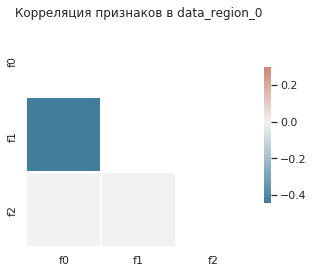

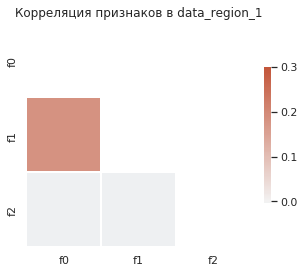

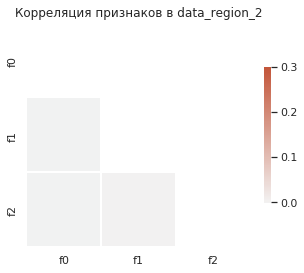

In [13]:
def corr_martix_plot(df):
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = df.loc[:, ['f0','f1','f2']].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(5, 5))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, vmax = 0.3, cbar_kws={"shrink": .5})
    plt.title(f'Корреляция признаков в {df.name}')

process_all_df(corr_martix_plot, data_list)

Матрицы корреляции показывают, что в регионе 0 наблюдается отрицательная зависимость признака f0 и f1 на уровне -0.44.
При построении модели в этом регионе попробуем убрать один из этих признаков.

Перед дальнейшим анализом посмотрим на распределение целевого признака в регионах:

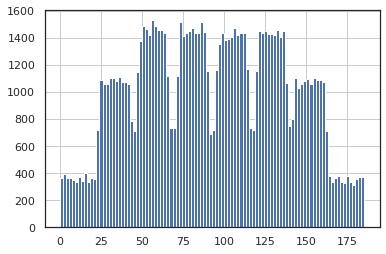

In [14]:
data_region_0['product'].hist(bins=100)

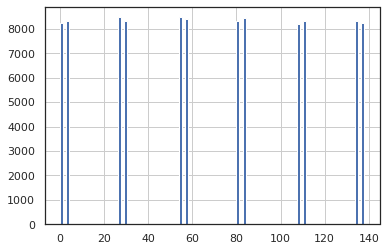

In [15]:
data_region_1['product'].hist(bins=100)

Скорее всего мы наблюдаем такое распределение поскольку данные синтетические. В реальности такое распределение означало бы что мы просто много раз замерили значения в маленьком наборе скважин – в нашем случае в 12-и. 

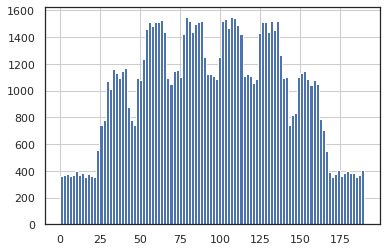

In [16]:
data_region_2['product'].hist(bins=100)

### Вывод

На данном этапе мы загрузили, проверили и обработали данные для дальнейшей работы с ними.

1. Проверили пропуски в таблицах. 
2. Проверили типы данных – все типы определились адекватно задаче.

3. Обработали дубликаты скважин.  
    Некоторые скважины появляются по 2 раза, при этом с разными признаками. Какой-либо временной связи в упорядоченных изначальным способом не наблюдается – количество продукта может как и расти, так и падать от наблюдения к наблюдению.  
    <ins>Возможная причина появления дубликатов</ins> – были произведены повторные замеры признаков и старые данные по какой-либо причине не были удалены.  
    Так как мы не можем определить актуальные значения признаков, мы удаляли обе записи о скважинах. 

4. Исследовали корреляцию признаков.
Матрицы корреляции показывают, что в регионе 0 наблюдается отрицательная зависимость признака f0 и f1 на уровне -0.44. При построении модели в этом регионе попробуем убрать один из этих признаков.

## 2. Обучение и проверка модели

Для обучения модели и её валидации нам необходимы два типа выборок: обучающая и валидационная. Исходные данные будем разбивать в соотношении 75:25.

Обычно перед обучением лейной модели используется нормализация признаков для придания им одинакового веса, однако в модели `LinearRegression` из библиотеки `scikit-learn` уже встроен инструмент, позволяющий нормализовать признаки, поэтому будем пользоваться им.

In [17]:
def full_model(data):
    #разделим признаки
    features = data.drop(['id', 'product'], axis = 1)
    target = data['product']
    
    #разделим выборки
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.25, 
                                                                              #stratify=target, 
                                                                              random_state=RS)

    #инициируем модель
    model = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=-1, positive=False)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions_series = pd.Series(data = predictions, index = features_valid.index)
    
    model_rmse = mse(target_valid, predictions) ** 0.5
    mean_product_predicted = predictions.mean()
    model_mae = mae(target_valid, predictions)
    

    try:
        print("\033[1m" + data.name + "\033[0m" )
    except AttributeError:
        print("Измененная таблица")
        
    finally:
        print('Средний запас предсказанного сырья: {:.4f}'.format(mean_product_predicted))
        print('RMSE модели: {:.4f}'.format(model_rmse))
        print('MAE модели: {:.4f}'.format(model_mae))
        return predictions_series, target_valid

Поскольку у нас только 2 логических гиперпараметра: `fit_intercept` и `normalize`, они переберались вручную. Наилучшие результаты были получены при центрировании прямых через `fit_intercept=True` (когда True, параметр `normalize` не используется). 

При вызове модели также будем сохранять предсказания модели и реальные значения признаков в соответствующие переменные.

In [18]:
#построим модель по всем признакам:
data_region_0_predict, data_region_0_target_valid = full_model(data_region_0)

data_region_0
Средний запас предсказанного сырья: 92.5731
RMSE модели: 37.7414
MAE модели: 31.0814


In [19]:
#уберем 1-й признак
data_region_0_predict, data_region_0_target_valid = full_model(data_region_0.drop('f1', axis = 1))

Измененная таблица
Средний запас предсказанного сырья: 92.5160
RMSE модели: 38.2898
MAE модели: 31.4715


In [20]:
#уберем 0-й признак
data_region_0_predict, data_region_0_target_valid = full_model(data_region_0.drop('f0', axis = 1))

Измененная таблица
Средний запас предсказанного сырья: 92.6012
RMSE модели: 37.8541
MAE модели: 31.1646


При удалении одного из признаков модель начинает предсказывать хуже. 

Мы наблюдали корреляцию признаков на уровне -0.44, это граничное значение. Нам кажется, что в задаче с высоким риском, когда предсказание можно сделать только один раз, лучше избавиться от одного из таких признаков для того, чтобы минимизировать случайность в наших будущих предсказаниях.

Удалять будем признак f0 – без него мы получили более высокую точность на валидаиционной выборке чем без f1. 

In [21]:
data_region_1_predict, data_region_1_target_valid = full_model(data_region_1)

data_region_1
Средний запас предсказанного сырья: 68.9174
RMSE модели: 0.8922
MAE модели: 0.7201


In [22]:
data_region_2_predict, data_region_2_target_valid = full_model(data_region_2)

data_region_2
Средний запас предсказанного сырья: 95.1765
RMSE модели: 40.0905
MAE модели: 32.8385


### Вывод

На данном этапе мы:  
Выбрали наилучшую модель, предсказывающую количество продукта в скважине.  
Предсказали средний запас сырья для каждого региона.

После анализа для региона 0 было решено исключить признак f0.

Результаты предсказаний модели:

Регион | Средний запас предсказанного сырья | RMSE | MAE модели
:---|---|---|---
region_0 | 92.6012 | 37.8541 | 31.1646
region_1 | 68.9174 | 0.8922 | 0.7201
region_2 | 95.1765 | 40.0905 | 32.8385

## 3. Подготовка к расчёту прибыли

###  Создание переменных с ключевыми значениями.

In [23]:
#При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
ALL_WELLS = 500 
N_WELLS = 200

#Бюджет на разработку скважин в регионе — 10 млрд рублей
BUDGET = 10_000_000_000

#Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
PROFIT_PER_UNIT = 450_000

#После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.
LOSS_TRESHOLD = 0.025

### Рассчёт достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение полученного объёма сырья со средним запасом в каждом регионе.

Мы хотим чтобы доход со скважины был больше чем выделенный на нее бюджет:

Формула для одной скважины:

`Бюджет на скважину <= Количество продукта в скважине * Доход с единицы продукта`

In [24]:
budget_per_well = BUDGET / N_WELLS
print('Бюджет на скважину, руб.: ', budget_per_well) 

product_min_value = budget_per_well / PROFIT_PER_UNIT
print('Минимальное среднее количество продукта в скважине: {:.2f}'.format(product_min_value))

Бюджет на скважину, руб.:  50000000.0
Минимальное среднее количество продукта в скважине: 111.11


Мы получили что в среднем в скважине должно быть как минимум 111.11 единиц продукта.
Сравним полученный объём сырья со средним запасом в каждом регионе:

Регион | Средний запас сырья | MAE модели
:---|---|---
region_0 | 92.6012 | 31.1646
region_1 | 68.9174 | 0.7201
region_2 | 95.1765 | 32.8385

Как становится видно, средний запас сырья не составляет 111 ни в одном из регионов. Однако так как мы будем брать топ 200 скважин из 500, вполне возможно что один из регионов подойдет для разработки.

### Выводы по этапу подготовки расчёта прибыли.

Бюджет на скважину, руб.: 50000000  
Минимальное среднее количество продукта в скважине: 111.11

Мы получили, что в среднем в скважине должно быть как минимум 111.11 единиц продукта.
Средний запас сырья не составляет 111 ни в одном из регионов. Однако так как мы будем брать топ 200 скважин из 500, вполне возможно что один из регионов подойдет для разработки.

## 4. Функция для расчёта прибыли

In [25]:
def predicted_profit_for_n_wells(target, predictions, n_wells):
    #выбор n скважин с максимальными значениями предсказаний
    chosen_wells = predictions.sort_values(ascending = False).head(n_wells)
    real_product_in_chosen_wells = target[chosen_wells.index]
    
    #расчет суммарного целевого значения объёма сырья
    summ_product = real_product_in_chosen_wells.sum()
    
    #чистая прибыль для полученного объёма сырья
    summ_profit = (summ_product * PROFIT_PER_UNIT) - BUDGET
    return summ_profit

## 5. Риски и прибыль для каждого региона

### Поиск распределения прибыли техникой Bootstrap с 1000 выборок.

Для проверки нашей модели будем использовать технику Bootstrap с 1000 выборок.
Как это будет выглядеть:
1. 1000 раз модель отобрёт 200 самых прибыльных скважин из случайных 500 
2. Для каждой выборки мы посчитаем реальную прибыль
3. Для полученных значений мы найдем среднее, доверительный интервал и риски.

In [26]:
state = np.random.RandomState(RS)

def bootstrap_k_times(predictions, target, k):
    values = []
    for i in tqdm(range(k)):
        target_subsample = target.sample(n = ALL_WELLS, replace = True, random_state = state)
        probs_subsample = predictions[target_subsample.index]

        values.append(predicted_profit_for_n_wells(target_subsample, probs_subsample, N_WELLS))
        
    values = pd.Series(values)
    return values


In [27]:
profit_values_reg_0 = bootstrap_k_times(data_region_0_predict, data_region_0_target_valid, 1000)
profit_values_reg_1 = bootstrap_k_times(data_region_1_predict, data_region_1_target_valid, 1000)
profit_values_reg_2 = bootstrap_k_times(data_region_2_predict, data_region_2_target_valid, 1000)

100%|██████████| 1000/1000 [00:05<00:00, 175.03it/s]


In [28]:
pd.options.display.float_format = '{:,.2f}'.format
profit_values_reg_0.head()

0   171,850,201.88
1   868,354,287.78
2   460,678,339.59
3   844,481,563.26
4   624,365,217.91
dtype: float64

### Средняя прибыль, 95%-й доверительный интервал и риск убытков.

#### Регион 0

Text(0.5, 1.0, 'Распределение предсказаний прибыли в регионе')

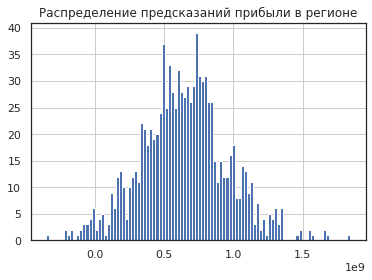

In [29]:
profit_values_reg_0.hist(bins=100)
plt.title('Распределение предсказаний прибыли в регионе')

In [30]:
def mean_profit(profit_values):
    print('Средняя прибыль для региона: {:.2f} руб.'.format(profit_values.mean()))
    
mean_profit(profit_values_reg_0)

Средняя прибыль для региона: 643117581.33 руб.


Найдем 95%-й доверительный интервал:

In [31]:
def confidence_interval(profit_values):
    lower = profit_values.quantile(0.025)
    upper = profit_values.quantile(0.975)

    print('Нижняя граница: {:.2f} руб.'.format(lower))
    print('Верхняя граница: {:.2f} руб.'.format(upper))
    
confidence_interval(profit_values_reg_0)

Нижняя граница: 8353161.01 руб.
Верхняя граница: 1286166993.35 руб.


Риск убытков. Убыток — это отрицательная прибыль.

In [32]:
def loss_count(profit_values):   
    losses = profit_values.pipe(lambda x: x[x<0])
    losses_amount = losses.count()
    all_values = profit_values.count()

    chance_of_loss = losses_amount / all_values
    print('Риск убытков: {:.2%}'.format(chance_of_loss))

loss_count(profit_values_reg_0)

Риск убытков: 2.40%


Таким образом для **региона 0**:  
Средняя прибыль для региона: 643 117 581 руб.

Найдем 95%-й доверительный интервал:
Нижняя граница: 8 353 161 руб.
Верхняя граница: 1 286 166 993 руб.

Риск убытков: 2.40%

#### Регион 1

Text(0.5, 1.0, 'Распределение предсказаний прибыли в регионе')

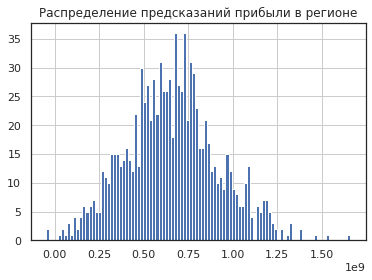

In [33]:
profit_values_reg_1.hist(bins=100)
plt.title('Распределение предсказаний прибыли в регионе')

Найдем среднюю прибыль для региона, 95%-й доверительный интервал и риск убытков:

In [34]:
mean_profit(profit_values_reg_1)
confidence_interval(profit_values_reg_1)
loss_count(profit_values_reg_1)

Средняя прибыль для региона: 657662257.35 руб.
Нижняя граница: 170958701.53 руб.
Верхняя граница: 1191199239.74 руб.
Риск убытков: 0.20%


#### Регион 2

Text(0.5, 1.0, 'Распределение предсказаний прибыли в регионе')

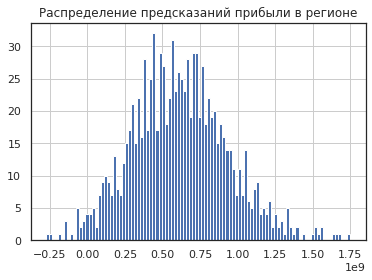

In [35]:
profit_values_reg_2.hist(bins=100)
plt.title('Распределение предсказаний прибыли в регионе')

In [36]:
mean_profit(profit_values_reg_2)
confidence_interval(profit_values_reg_2)
loss_count(profit_values_reg_2)

Средняя прибыль для региона: 614662404.41 руб.
Нижняя граница: 32413225.09 руб.
Верхняя граница: 1277386124.57 руб.
Риск убытков: 2.00%


### Выводы: выбор региона для разработки скважин и его обоснование.

Согласно поставленной задаче, после оценки рисков необходимо оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбириается регион с наибольшей средней прибылью.

Оценка рисков в регионах показала, что при использовании модели вероятность убытков меньше 2.5% во всех регионах. 
Из них самая высокая средняя прибыль предсказана в регионе 1. 

<ins>Статистика по региону 1:</ins>  

Средняя прибыль для региона: 657 662 257 руб.

95%-й доверительный интервал:   
Нижняя граница: 170 958 701.53 руб.  
Верхняя граница: 1 191 199 239 руб.

Риск убытков: 0.20%

Таким образом, рекомендованный для разработки регион: **Регион 1.**

## Общий вывод

**1.** На первом шаге мы загрузили, проверили и обработали данные для дальнейшей работы с ними.

    1). Проверили пропуски в таблицах. 
    2). Проверили типы данных.
    3). Обработали дубликаты скважин.  
    Возможная причина появления дубликатов – были произведены повторные замеры признаков и старые данные по какой-либо причине не были удалены.  
    Так как мы не можем определить актуальные значения признаков, мы удаляли обе записи о скважинах. 
    4). Исследовали корреляцию признаков.
    В регионе 0 наблюдается отрицательная зависимость признаков "f0" и "f1" на уровне -0.44. При построении модели в этом регионе мы учли эту корреляцию.

**2.** На втором шаге мы выбрали наилучшую модель, предсказывающую количество продукта в скважине, а также предсказали средний запас сырья для каждого региона.

Результаты предсказаний модели:

Регион | Средний запас предсказанного сырья | RMSE | MAE модели
:---|---|---|---
Регион 0 | 92.6012 | 37.8541 | 31.1646
Регион 1 | 68.9174 | 0.8922 | 0.7201
Регион 2 | 95.1765 | 40.0905 | 32.8385

**3.** Далее мы провели подготовку к расчёту прибыли. 

Создали переменные с ключевыми значениями и составили формулу прибыльности для одной скважины:

`Бюджет на скважину <= Количество продукта в скважине * Доход с единицы продукта`

Мы получили, что в среднем в скважине должно быть как минимум 111 единиц продукта, бюджет на одну скважину составил 50 000 000 руб. Средний запас сырья не составлял 111 единиц ни в одном из регионов. Но поскольку мы будем брать 200 лучших скважин из 500, мы продолжили наши расчёты.

**4.** После мы написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

**5.** На последнем этапе были подсчитаны риски и прибыль для каждого региона.

Для этого мы построили распределение прибыли техникой Bootstrap с 1000 выборок по предсказаниям нашей модели.

1. 1000 раз модель отобрала 200 самых прибыльных скважин из случайных 500; 
2. Для каждого набора была расчитана суммарная прибыль;
3. Для полученного распределения значений прибыли мы нашли среднее, 95%-й доверительный интервал и риски.

Оценка рисков в регионах показала, что при использовании модели вероятность убытков меньше 2.5% во всех регионах. 
Из них самая высокая средняя прибыль предсказана в регионе 1. 

<ins>Статистика по региону 1:</ins>  

Средняя прибыль для региона: 657 662 257 руб.

95%-й доверительный интервал:   
Нижняя граница: 170 958 701.53 руб.  
Верхняя граница: 1 191 199 239 руб.

Риск убытков: 0.20%

Таким образом был выбран рекомендованный для разработки регион: **Регион 1.**